# Motif Analysis

Analysing graphs according to their 3-node motifs.


In [29]:
import os
import os.path as op
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime

import os
import os.path as op
import time
import datetime
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy


# PCA Packages
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

# Graph analysis functions
from compile_graphs_dataset import get_graphs, graph_properties, exclude_empty_graphs

# Motif analysis functions
from motif_helper_functions import motifs, motif_counter, rasterplot, biplot, biplot_3d, Arrow3D, biplot_with_inset


In [30]:
# +++ Set Paths +++
# Input directory for graph and motif data
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'
# Output directory for figures
output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'

In [31]:

# +++ Set Paths +++
# Input directory for graph and motif data
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'
# Output directory for tables
output_dir = op.join(graph_dir, 'output')
# Output directory for figures
output_figures = op.join(graph_dir, 'figures')



# +++ Import Data +++
# --------------------- Import graph data ---------------------------------------
graph_data = op.join(output_dir, 'graph_data.csv')
df = pd.read_csv(graph_data, index_col=0)

# --------------------- Add motif counts ---------------------------------------
# If already counted and motif_counts.csv exists, imports motif count data
try:
    # Import motif count data
    motif_counts = pd.read_csv(op.join(output_dir, 'motif_counts.csv'))
    # df = pd.read_csv(op.join(graph_data))
except FileNotFoundError:
    print('----- Error: Cannot find {}} -----\nIt seems motifs have not been counted yet.\nRun motifs.py to count motifs before running this cell.'.format(graph_data))

# --- Compile graphs data (basic properties and motifs) and save ---
for column in motif_counts.columns:
    df[column] = motif_counts[column]



In [58]:
df
np.unique(df.subj.values).shape
df.shape

(2845, 48)

In [32]:
# ----------- Quick inspection -----------
# shows missing values as null count (if non-null count == number of entries, then there are no missing values)
df.info()
df_with_nan = df[df.isna().any(axis=1)] # nan values are mostly either in the semantic coherence measures or in the ollie confidence measures


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845 entries, 0 to 2844
Data columns (total 45 columns):
subj                          2845 non-null int64
tat                           2845 non-null int64
words                         2845 non-null int64
sentences                     2845 non-null int64
nodes                         2845 non-null int64
edges                         2845 non-null int64
unconnected                   2845 non-null int64
average_total_degree          2845 non-null float64
parallel_edges                2845 non-null int64
bidirectional_edges           2845 non-null int64
lsc                           2845 non-null int64
lcc                           2845 non-null int64
L1                            2845 non-null int64
L2                            2845 non-null int64
L3                            2845 non-null int64
sizes_connected_components    2845 non-null object
connected_components          2845 non-null int64
max_degree_centrality         2845 non-n

In [59]:
df.lsc


0       3
1       1
2       1
3       1
4       1
       ..
2840    2
2841    2
2842    1
2843    3
2844    3
Name: lsc, Length: 2845, dtype: int64

In [60]:
df.bidirectional_edges

0       5
1       0
2       0
3       0
4       0
       ..
2840    3
2841    3
2842    1
2843    0
2844    0
Name: bidirectional_edges, Length: 2845, dtype: int64

Variance explained: [74.2 16.5  4.4  3.9  0.6  0.2  0.   0.   0.   0.   0. ]
Cumulative variance explained: [74.2 90.7 95.1 99.  99.6 99.8 99.8 99.8 99.8 99.8 99.8]
      PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
m01  0.74 -0.66 -0.09  0.11  0.03 -0.01  0.00 -0.00  0.00 -0.00 -0.00
m02  0.65  0.67 -0.04 -0.35 -0.02 -0.02 -0.00 -0.00 -0.00  0.00 -0.00
m03  0.09 -0.03  0.94  0.01 -0.34  0.02 -0.04  0.01 -0.02 -0.00 -0.01
m04  0.16  0.33 -0.05  0.92 -0.10 -0.03  0.01 -0.00 -0.00 -0.00 -0.00
m05  0.02  0.02 -0.01  0.03  0.02  1.00 -0.00 -0.03 -0.01 -0.01 -0.00
m06  0.00 -0.00  0.01  0.00 -0.01  0.00 -0.02  0.01  0.26  0.06  0.96
m07  0.04  0.06  0.33  0.09  0.93 -0.02 -0.05  0.01 -0.00 -0.02  0.01
m08  0.00  0.00  0.06 -0.00  0.04 -0.00  0.98 -0.20 -0.02  0.05  0.03
m09  0.00  0.00 -0.00 -0.00  0.00  0.03  0.20  0.98 -0.01  0.03 -0.00
m10  0.00  0.00  0.01 -0.00 -0.00  0.01  0.05  0.01  0.89 -0.38 -0.22
m11  0.00  0.00  0.01  0.00  0.02  0.01 -0.04 -0.01  0.35  0.92 -

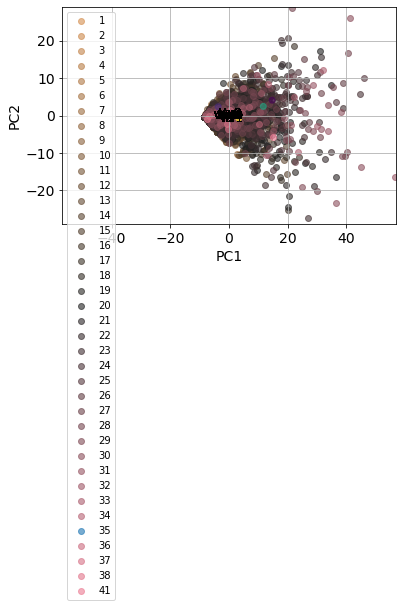

In [33]:

# ---------------------- PCA ----------------------
# Do not standardize data, since motif counts are on the same scale
# and also to avoid taking sparse motifs (motifs over m07) into account too much

motif_cols = list(motifs.keys())[:-1]

# PCA
n_components = len(motif_cols) - 1
pca = PCA(n_components=n_components)
pca.fit(df[motif_cols].values)
variance = pca.explained_variance_ratio_  # calculate variance ratios
var = np.cumsum(
    np.round(pca.explained_variance_ratio_, decimals=3) * 100)
print('Variance explained: {}'.format(
    np.round(variance, decimals=3) * 100))
print('Cumulative variance explained: {}'.format(
    var))
# Get Loadings
pc_cols = ['PC' + str(n + 1) for n in range(0, n_components)]
# ----------------------- Plot PCA ----------------------------------------------
loadings = pd.DataFrame(pca.components_.T, columns=pc_cols, index=motif_cols)
print(loadings.round(2))
loadings.round(2).to_csv(op.join(graph_dir, 'pca_loadings.csv'))
components = loadings.values
# --- Biplot with unrotated components ---
X_new = pca.fit_transform(df[motif_cols])
biplot(X_new[:, 0:2], np.transpose(pca.components_[0:2, :]), df.edges)
# output = op.join(output_figures, 'PCA_biplot_unrotated' +
#                  '_{0}'.format(str(datetime.date.today())))
# plt.savefig(output)
plt.show()

In [34]:
score = X_new[:, 0:3]


# --------------------- Correlate with motif counts ---------------------------------------
for pc in range(0, 3):
    df['PC{}_score'.format(pc+1)] = score[:, pc]

gra_columns = list(df.columns)[2:31] 
syn_columns = list(df.columns)[46:69]
nlp_columns = list(df.columns)[70:-3]

In [35]:
# --------------------- Import Oasis graphs ---------------------------------------
oasis_graph_dir = '/Users/CN/Dropbox/speech_graphs/oasis'
oasis_output_figures = op.join(oasis_graph_dir, 'figures')

oasis_graphs, oasis_filelist = get_graphs(oasis_graph_dir)
oasis_graphs, oasis_filelist = exclude_empty_graphs(oasis_graphs, oasis_filelist, be_quiet=True)

# --------------------- Import Oasis graph data ---------------------------------------
oasis = pd.read_csv(op.join(oasis_graph_dir, 'output/graph_data.csv'))
print('Described {0} graphs.\n{1} subjects described {2} ± {3} pictures.'.format(oasis.shape[0], len(oasis.subj.unique()), round(oasis.subj.value_counts().mean(),2), round(oasis.subj.value_counts().std(),2)))


# Make subj and tat categorical
oasis.subj = pd.Categorical(oasis.subj.astype('str'))
oasis.tat = pd.Categorical(oasis.tat.astype('str'))


id_data = pd.read_csv('/Users/CN/Documents/Projects/Cambridge/data/oasis/ids_oasis.csv', delimiter=';')
oasis['group'] = np.nan
for s, subj in enumerate(id_data.Subject):
    oasis.at[oasis.subj == str(subj), 'group'] = id_data.Group[s]

oasis.group = pd.Categorical(oasis.group.astype('str'))

# Sort oasis by group
oasis.sort_values(by=['group', 'subj'], ascending=[True, True], inplace=True)
oasis = oasis.reset_index()
# oasis.group_n = oasis.group.cat.rename_categories({'CON': '1', 'FEP' : '2', 'ARMS': '3' })
oasis['group_n'] = None
oasis.group_n = oasis.group.cat.codes*100


print('--- Groups ---\n{}'.format(oasis.group.value_counts()))



Obtained 423 graphs. Excluded 0 empty graphs. Kept 423 graphs.
Described 423 graphs.
53 subjects described 7.98 ± 0.14 pictures.
--- Groups ---
ARMS    191
FEP     128
CON     104
Name: group, dtype: int64


In [36]:
# --------------------- Add Oasis motif counts ---------------------------------------
oasis_output_dir = op.join(oasis_graph_dir, 'output')
# If already counted and oasis_motif_counts.csv exists, imports motif count data
try:
    # Import motif count data
    oasis_motif_counts = pd.read_csv(op.join(oasis_output_dir, 'motif_counts.csv'))
    # df = pd.read_csv(op.join(graph_data))
except FileNotFoundError:
    print('----- Error: Cannot find {}} -----\nIt seems motifs have not been counted yet.\nRun motifs.py to count motifs before running this cell.'.format(graph_data))

# --- Compile graphs data (basic properties and motifs) and save ---
for column in oasis_motif_counts.columns:
    oasis[column] = oasis_motif_counts[column]

In [37]:
# --------------------- Add PC scores ---------------------------------------
X_new = pca.fit_transform(oasis[motif_cols])
oasis['PC1_score'] = X_new[:,0]
oasis['PC2_score'] = X_new[:,1]
oasis['PC3_score'] = X_new[:,2]


In [38]:
# Exclude subject 12 because of bad quality transcripts
oasis.shape
oasis = oasis[oasis.subj.values != '12']


In [39]:


oasis['inverse_nodes'] = 1/oasis.nodes
oasis['max_degree_centrality_abs'] = oasis.max_degree_centrality * oasis.nodes
oasis['max_indegree_centrality_abs'] = oasis.max_indegree_centrality_value * oasis.nodes
oasis['max_outdegree_centrality_abs'] = oasis.max_outdegree_centrality_value * oasis.nodes

In [40]:
# --------------------- Average across TAT stimuli ( = one datapoint per participant ) ---------------------------------------
oasis_avg = (oasis.groupby((oasis.subj != oasis.subj.shift()).cumsum())
                  .mean()
                  .reset_index(drop=True))

oasis_avg.group_n.value_counts()
# oasis_avg['group'] = oasis_avg.group_n.astype("category")
oasis_avg['group'] = pd.Categorical(oasis_avg.group_n)

oasis_avg.group = oasis_avg.group.cat.rename_categories({0: 'CHR', -56: 'FEP', 100: 'CON'})
oasis_avg.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'], inplace=True)
oasis_avg.group.value_counts()


CHR    24
FEP    16
CON    12
Name: group, dtype: int64

In [41]:


oasis.to_csv(op.join(oasis_output_dir, 'graph_data_with_pca.csv'))
oasis_avg.to_csv(op.join(oasis_output_dir, 'graph_data_with_pca_avg.csv'))


In [42]:
variable_list = ['PC1_score', 'PC2_score', 'PC3_score']
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

for v,variable in enumerate(variable_list):
    print(scipy.stats.shapiro(oasis_avg[variable]))

(0.9686427116394043, 0.18499170243740082)
(0.9658923149108887, 0.1409137099981308)
(0.9768897891044617, 0.4035457670688629)


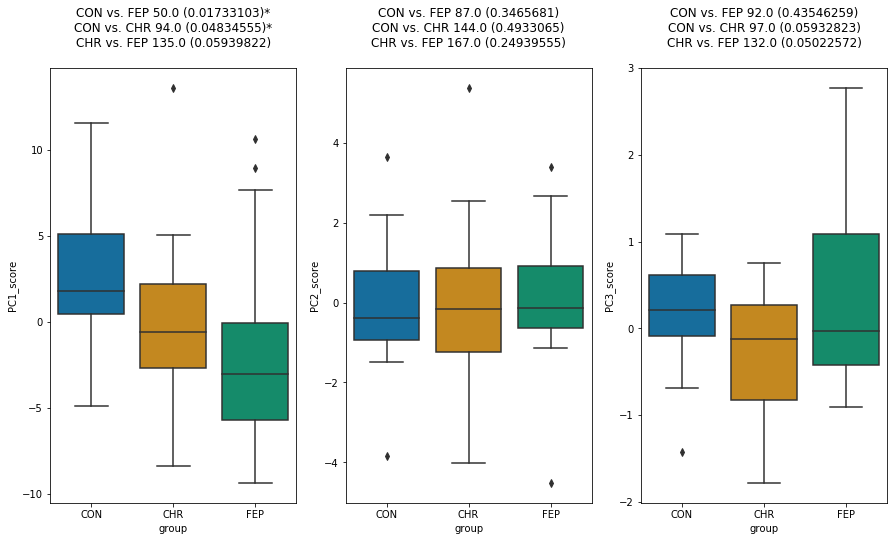

In [46]:



variable_list = ['PC1_score', 'PC2_score', 'PC3_score']
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(15, 8))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )  
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(oasis_output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


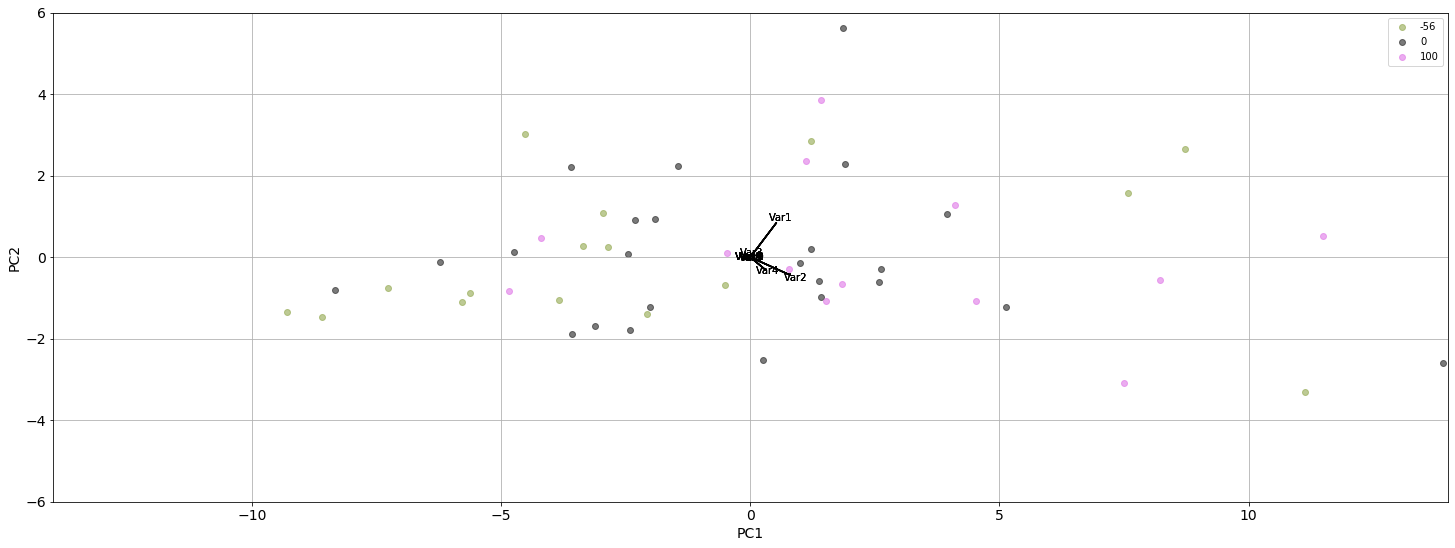

In [61]:
# --- Biplot with unrotated components ---
fig = plt.figure(figsize=(25, 9))
X_new = pca.fit_transform(oasis_avg[motif_cols])
biplot(X_new[:, 0:2], np.transpose(pca.components_[0:2, :]), oasis_avg.group_n)
output = op.join(oasis_output_figures, 'PCA_biplot_unrotated' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


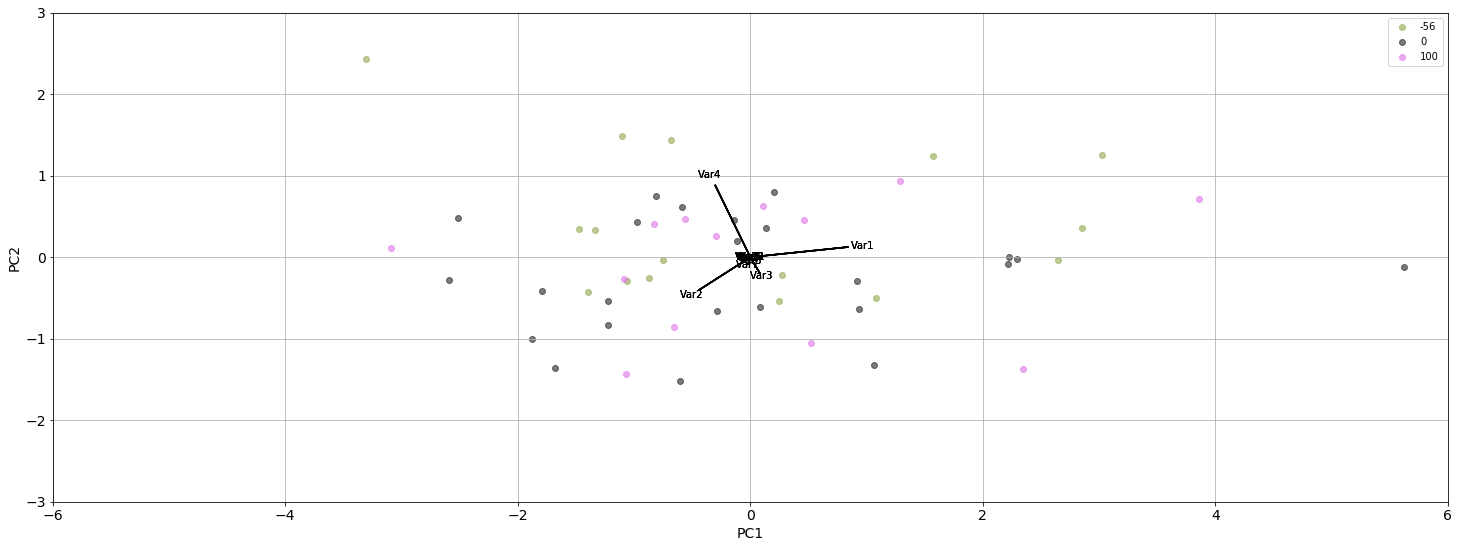

In [62]:
# --- Biplot with unrotated components ---
fig = plt.figure(figsize=(25, 9))
X_new = pca.fit_transform(oasis_avg[motif_cols])
biplot(X_new[:, 1:3], np.transpose(pca.components_[1:3, :]), oasis_avg.group_n)
output = op.join(oasis_output_figures, 'PCA_biplot_unrotated_PC2-PC3' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


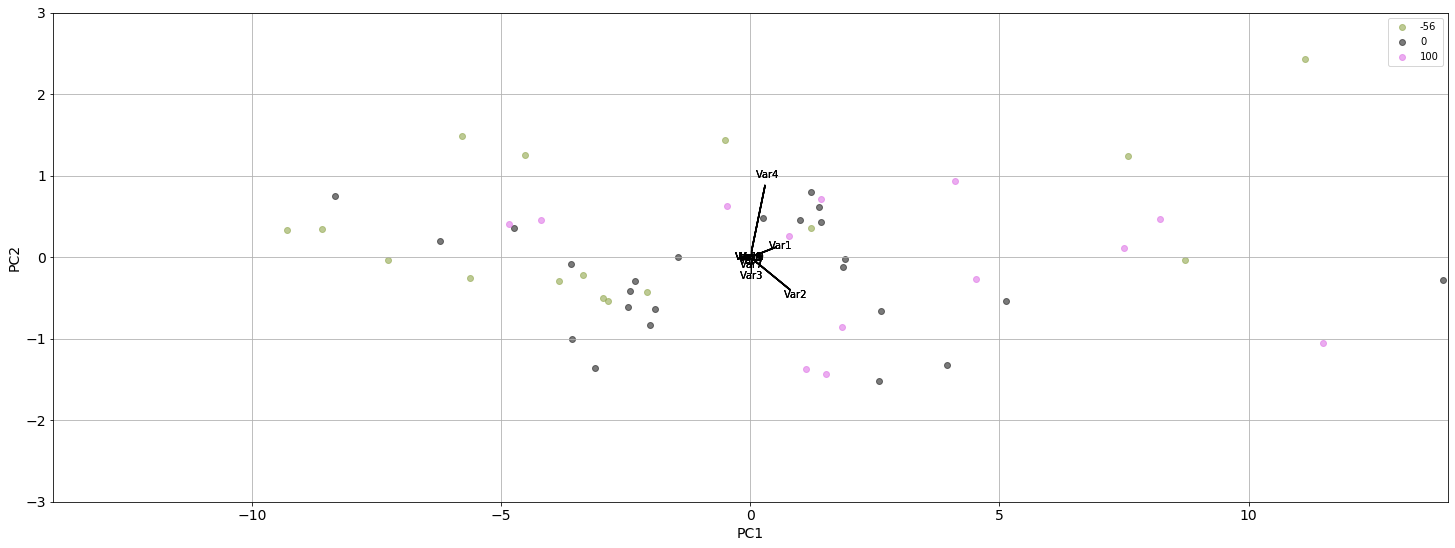

In [63]:
# --- Biplot with unrotated components ---
fig = plt.figure(figsize=(25, 9))
X_new = pca.fit_transform(oasis_avg[motif_cols])
biplot(X_new[:, 0:3:2], np.transpose(pca.components_[0:3:2, :]), oasis_avg.group_n)
output = op.join(oasis_output_figures, 'PCA_biplot_unrotated_PC1-PC3' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

In [64]:
oasis.group_n.value_counts()

 0      191
-56     128
 100    104
Name: group_n, dtype: int64

In [65]:
oasis.group.value_counts()

ARMS    191
FEP     128
CON     104
Name: group, dtype: int64

In [ ]:
oasis.group.cat.codes*100
# *100
